# **CSE 5522 Lab #4: Neural Networks**


---
---
# **Part 4: MLP classification of vowels (60 pts)**

In this Part 4 we will take a different approach: We will instead use a *multi-layer perceptron* which should be capable of solving even non-linearly separable problems.

This should allow us to predict vowel classes directly from formants, ignoring the vocal tract features completely.

---

**4.1** With the formant data from Part 2, use PyTorch to construct a 2-layer MLP with 100 hidden units, predicting the vowel class.

The traditional way to handle multi-class (non-binary) problems such as this is to have a softmax output with a cross entropy loss.  Pytorch does this using the [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html) function, which expects as its input the linear layer (it builds the softmax function into the loss).

You will need to modify the hands-on example to use softmax output with cross-entropy as loss function. Review the linked documentation (you will need to be careful of the format expected for various inputs!)

Report and discuss results on the test set.

#Imports

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns

import time

import warnings

#Reading and preprocessing

In [2]:
url='https://raw.githubusercontent.com/efosler/cse5522data/master/vowelfmts.csv'
df=pd.read_csv(url)

#Extract fundamental frequencies
data_f1=np.array(df['f1'],dtype='float32')
data_f2=np.array(df['f2'],dtype='float32')
data_formants=np.transpose(np.vstack((data_f1,data_f2)))
del data_f1, data_f2 
labels_formants=['f1','f2']

#Extract vowel, it's categorical so we create dummy variables for each vowel
data_vowels=pd.get_dummies(df['vowel'])
labels_vowels=list(data_vowels.columns)
data_vowels=np.array(data_vowels,dtype='int_')
index_vowels={label:idx for idx,label in enumerate(labels_vowels)}
data_vowels_idx=np.array([index_vowels[vwl] for vwl in df['vowel']],dtype='int_')

# Train, test, split 80/20
train_formants, test_formants, train_vowels, test_vowels, train_vowels_idx, test_vowels_idx = \
  train_test_split(data_formants,data_vowels,data_vowels_idx)


There will be 4 different networks in this lab, we will store their accuracies here:

In [3]:
RESULTS = [[],[],[],[]]

#Network Architecture

In [4]:
class MLP(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(2, 100)
    self.layer2 = nn.Linear(100, 9)

  def forward(self, x):
    output = torch.sigmoid(self.layer1(x))
    return self.layer2(output)

#PyTorch Setup

In [5]:
def initializeWeights(model):
  for x in model.modules():
    if isinstance(x, nn.Linear):
      x.weight.data.normal_(0,1)

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(dev)

cuda


# Model and Training

In [6]:
def train(X, Y, model, loss_function, opti, epochs):
  losses = []
  model.train()
  for e in range(epochs):
    x = Variable(X, requires_grad=False).to(dev)
    y = Variable(Y.long(), requires_grad=False).to(dev)
    opti.zero_grad()
    y_hat = model(x)
    loss = loss_function.forward(y_hat, y)
    loss.backward()
    opti.step()
    losses.append(loss.data.cpu().numpy())
  return losses

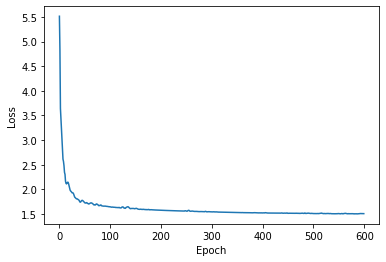

In [7]:
model = MLP().to(dev)
initializeWeights(model)
loss_fx = nn.CrossEntropyLoss().to(dev)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


X = torch.Tensor(train_formants).to(dev)
Y = torch.Tensor(train_vowels_idx).to(dev)

losses = train(X, Y, model, loss_fx, optimizer, 600)
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Testing

In [8]:
correct = 0
model.eval()
for i in range(test_formants.shape[0]):
  with torch.no_grad():
    prediction = model(torch.Tensor(test_formants[i]).to(dev))
    predicted_index = np.argmax(prediction.cpu().detach().numpy())
    if predicted_index == test_vowels_idx[i]:
      correct += 1.0
accuracy = (correct/i)*100.0
RESULTS[0].append(accuracy)
print(f"Accuracy: {accuracy:.4f}%")

Accuracy: 35.5995%


**4.2** You may be disappointed in the accuracy you achieve in the previous step. But it turns out that multi-class classification has results that are a bit tricky to interpret (compared to binary classification).

Let's turn your results into binary classification and re-evaluate.

Instead of considering all vowel classes at once, let's take one, say 'ih'. Convert your previous predictions to binary by saying they are true when 'ih' is the most likely prediction and false if any other vowel class is more likely.

Recalculate the accuracy based on this. Are the results more to your liking?

Repeat the above for each vowel class.

Can you explain why the results seem better when they are put in this form?

# Modify model and training

In [9]:
def train(X, Y, model, loss_function, opti, epochs):
  losses = []
  model.train()
  for e in range(epochs):
    x = Variable(X, requires_grad=False).to(dev)
    y = Variable(Y.long(), requires_grad=False).to(dev)
    opti.zero_grad()
    y_hat = model(x)
    loss = loss_function.forward(y_hat, y)
    loss.backward()
    opti.step()
    losses.append(loss.data.cpu().numpy())
  return losses

In [10]:
class BCN(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(2, 100)
    self.layer2 = nn.Linear(100, 2)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    return x

  # from https://medium.com/@prudhvirajnitjsr/simple-classifier-using-pytorch-37fba175c25c
  def predict(self, x):
    prediction = F.softmax(self.forward(x), dim=1)
    ans = []
    for t in prediction:
        if t[0]>t[1]:
            ans.append(0)
        else:
            ans.append(1)
    return torch.tensor(ans)

# Train and test

In [11]:
for i, vowel in enumerate(index_vowels):

  print(f"\"{vowel}\" vs \"others\" accuracy: ", end='')

  model = BCN().to(dev)
  initializeWeights(model)
  loss_fx = nn.CrossEntropyLoss().to(dev)
  optimizer = optim.SGD(model.parameters(), lr=0.0001)

  X = torch.Tensor(train_formants).to(dev)
  Y = torch.Tensor(np.apply_along_axis
                   (lambda x:(x==i), 0, train_vowels_idx)).to(dev)

  losses = train(X, Y, model, loss_fx, optimizer, 3000)
  x_test = torch.Tensor(test_formants).to(dev)
  y_actuals = np.apply_along_axis(lambda x:(x==i), 0, test_vowels_idx)
  a = accuracy_score(model.predict(x_test), y_actuals)
  RESULTS[1].append(a)
  print(a)

"ah" vs "others" accuracy: 0.6901234567901234
"ao" vs "others" accuracy: 0.9185185185185185
"ax" vs "others" accuracy: 0.9740740740740741
"eh" vs "others" accuracy: 0.928395061728395
"ey" vs "others" accuracy: 0.8308641975308642
"ih" vs "others" accuracy: 0.7876543209876543
"iy" vs "others" accuracy: 0.8407407407407408
"ow" vs "others" accuracy: 0.8358024691358025
"uw" vs "others" accuracy: 0.8679012345679012


I did expect an increase, maybe not this much. That being said, the more output nodes to a model, the higher the complexity and subsequently, lower accuracy i.e. it's easier for me to learn the formants of one vowel and then tell you whether test data fits or not. I only have to know 1 distribution instead of 9.

---
---

# **Part 5: MLP experimentation (40 pts)**

**5.1** Develop an experiment with 2 additional models by making variations of your model from Part 4 (e.g., widths, numbers of layers, activation functions, etc).   Create a short writeup explaining (1) why you chose the variations, and (2) how it affected performance on the test set.

#Experiment 1:


Before I start, I want to make a way to view and organize performance metrics

In [12]:
def init_db():  
  cols = ['ah', 'ao', 'ax', 'eh', 'ey', 'ih', 'iy', 'ow', 'uw', 'Average', "Stdev"]
  df = pd.DataFrame(np.zeros((12,11)),
                    index=[
                            ["Accuracy","Accuracy","Accuracy",
                             "Speed","Speed","Speed",
                             "Epochs","Epochs","Epochs",
                             "Loss","Loss","Loss"],
                            4*["Adam","SGD","SGDnest"]],
                    columns=cols)
  return df

In [13]:
def six_plots(bounds, losses, df):
    # Used in both rows
    sns.set(style='darkgrid')
    opti = ['Adam', 'SGD', 'SGDnest']
    vowels = list(index_vowels.keys())  

    # First row
    fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
    axs = [ax1,ax2,ax3]
    fig.set_figwidth(28)    

    for i in range(3):
      axs[i].set_title(opti[i])
      axs[i].set_xlabel('Epochs')
      for j in range(0,9):
        axs[i].plot(np.arange(0,bounds[i]), losses[i][j][:bounds[i]], label=vowels[j])
    axs[i].legend()
    plt.show()  

    # Second Row
    fig, (ax4,ax5,ax6) = plt.subplots(nrows=1, ncols=3)
    axs = [ax4,ax5,ax6]
    fig.set_figwidth(28)
    ax4.set_title("Speed")
    ax5.set_title("Accuracy")
    ax6.set_title("Loss")
    ax4.set_xlabel('Vowel')
    ax5.set_xlabel('Vowel')
    ax6.set_xlabel('Vowel')
    ax4.set_ylabel('Time (s)')
    ax5.set_ylabel('% Correct')
    ax6.set_ylabel('Loss')
    colors=['blue','orange', 'green']
    markers=['x', 'o', '+'] 
    

    for j in range(3):
      data = [df.loc['Speed', opti[j]].to_numpy().astype(float),
              df.loc['Accuracy', opti[j]].to_numpy().astype(float),
              df.loc['Loss', opti[j]].to_numpy().astype(float)]
      for k in range(3):
        axs[k].plot(vowels, data[j][:-2],markers[j],color=colors[j])
        axs[k].hlines(data[j][-2:-1], xmin=0,xmax=8, linestyles='dotted', colors=colors[j])
        axs[k].fill_between(np.arange(0,9), 
                        data[j][-2:-1]+data[j][-1:], 
                        data[j][-2:-1]-data[j][-1:], 
                        color=colors[j], alpha=0.15)
    plt.legend(opti)
    plt.show()  

Below is a slightly modified training function and a train/test framework

In [14]:
def train2(X, Y, model, loss_function, opti, epochs, loss_arr):
  model.train()
  for e in range(epochs):
    x = Variable(X, requires_grad=False).to(dev)
    y = Variable(Y.long(), requires_grad=False).to(dev)
    opti.zero_grad()
    y_hat = model(x)
    loss = loss_function.forward(y_hat, y)
    loss.backward()
    opti.step()
    loss_val = loss.data.cpu().numpy()
    loss_arr[e] = loss_val
  return e

In [15]:
def run_train_test(trX, trY, teX, teY, tr_fx, epochs, loss_arr, df, 
                   acc_arr=None, validation=False, val_set_size=None, start=None, req_imprv=None, attempts=None):

  print("STATUS\n"+27*"_")

  if validation:
    bounds = int(len(trX) * val_set_size)
    trXv = torch.Tensor(trX[bounds:]).to(dev)
    trYv = trY[bounds:]
    trX = trX[:bounds]
    trY = trY[:bounds]

  for i, vowel in enumerate(index_vowels):
    model = BCN().to(dev)
    optimizers = {'Adam' : optim.Adam(model.parameters(),lr=0.0003),
                  'SGD' : optim.SGD(model.parameters(), lr=0.0001, momentum=0.9),
                  'SGDnest' : optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, nesterov=True)}

    for j, opti in enumerate(optimizers):
      # Set up arguments
      args = []
      args.append(torch.Tensor(trX).to(dev))                # X
      args.append(torch.Tensor(np.apply_along_axis          # Y
                      (lambda x:(x==i), 0, trY)).to(dev))    
      args.append(model)                                    # model
      args.append(nn.CrossEntropyLoss().to(dev))            # loss_fx
      args.append(optimizers[opti])                         # optimizer
      args.append(epochs)                                   # epochs
      args.append(loss_arr[j][i])                           # loss_arr
      if validation:
        args.append(acc_arr[j][i])                          # acc_arr
        args.append(start)                                  # start
        args.append(req_imprv)                              # req_imprv
        args.append(attempts)                               # attempts
        args.append(trXv)                                   # Xv
        args.append(np.apply_along_axis                     # Yv
                      (lambda x:(x==i), 0, trYv))
      # Train and time
      initializeWeights(model)
      s = time.time()
      e = tr_fx(*args)
      s = time.time() - s
      l = losses[j][i][-1]

      # Test and report
      x_test = torch.Tensor(teX).to(dev)
      y_actuals = np.apply_along_axis(lambda x:(x==i), 0, teY)
      a = accuracy_score(model.predict(x_test), y_actuals)
      df[vowel].loc[['Accuracy','Speed','Epochs','Loss'],opti] = a,s,e,l                                                   
      print("#",end='')

As seen above, the first improvement I want to make is focused on optimizers:
  * SGD with momentum=0.9
  * SGD with nesterov momentum
  * Adam


In [16]:
df = init_db()
losses = np.zeros(shape=(3,9,1000))

run_train_test(train_formants, train_vowels_idx, test_formants, test_vowels_idx, train2, 1000, losses, df, 
                   acc_arr=None, validation=False, val_set_size=None, start=None, req_imprv=None, attempts=None)

STATUS
___________________________
###########################

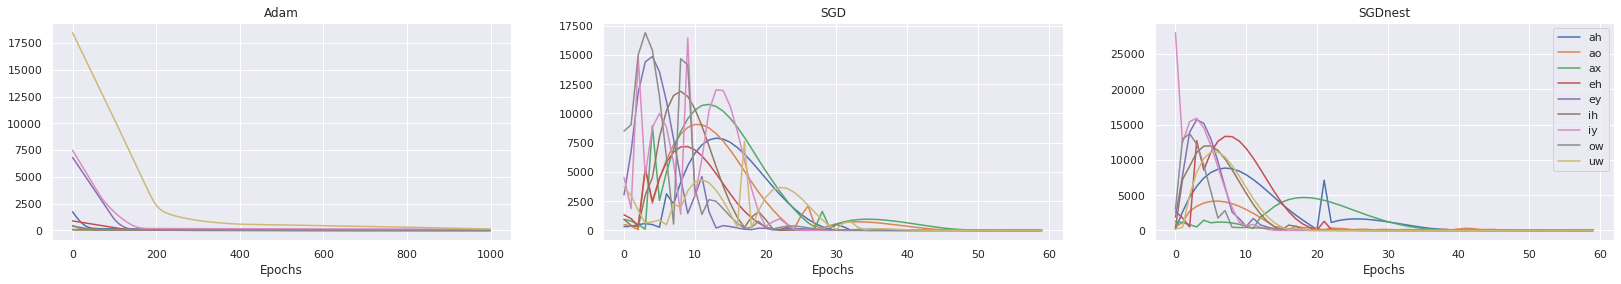

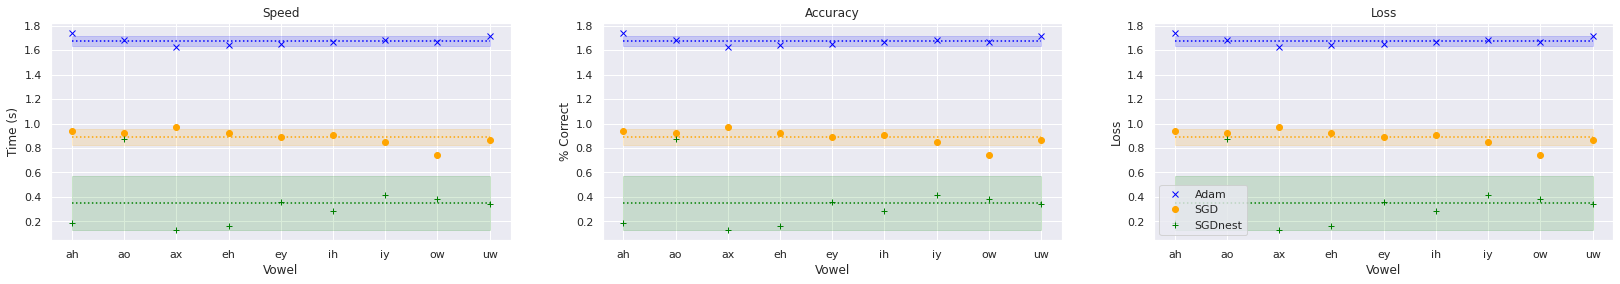

Total training time was 0.6522626042366028 minutes


ah          ao  ...     Average      Stdev
Accuracy Adam       0.900000    0.832099  ...    0.851440   0.080838
         SGD        0.937037    0.918519  ...    0.889026   0.067055
         SGDnest    0.937037    0.918519  ...    0.900686   0.042909
Speed    Adam       1.742178    1.681107  ...    1.674567   0.037233
         SGD        1.328416    1.314872  ...    1.295279   0.023189
         SGDnest    1.429930    1.329160  ...    1.378571   0.029980
Epochs   Adam     999.000000  999.000000  ...  999.000000   0.000000
         SGD      999.000000  999.000000  ...  999.000000   0.000000
         SGDnest  999.000000  999.000000  ...  999.000000   0.000000
Loss     Adam       2.831098    2.319458  ...   29.904142  52.421454
         SGD        0.188181    0.260139  ...    0.320037   0.161400
         SGDnest    0.183166    0.869573  ...    0.347428   0.221338

[12 rows x 11 columns]

In [17]:
df['Average'] = df.iloc[:,:-2].mean(axis=1)
df['Stdev'] = df.iloc[:,:-2].std(axis=1)
# these bounds effect the x axis on the top 3 graphs. Adjust if cut-off
six_plots([1000,60,60],losses,df)
print(f"Total training time was {np.sum(df.iloc[3:6,:-2].sum(axis=1).to_numpy())/60} minutes")
display(df)

Results (values vary, trends don't seem to):
* Accuracy: All of the optimizers I tested seemed to yield similar and fairly good accuracy deviating only by 4-5%.

* Speed: Even with a more agressive learning rate, Adam was about 20% slower than both SGD optimizers. SGD without nesterov was the fastest.

* Loss: SGD w/ nesterov had the lowest average loss followed by SGD. Adam performed on par only with 'eh' and was significantly higher than the others.

Optimizers:
* Adam: Although a lot of unofficial pytorch examples and docs seem to use Adam as their optimizer, it lagged behind the other two. I tried increasing the epochs for Adam but certain vowels began to overfit and had 0.0 loss. For this experiment I decided to keep the epochs constant. Somehow, the Adam model still performed almost identically to the SGD models even though they appeared to be properly trained. A big part of Adam is that it uses an adaptive learning rate that is different for every parameter. This is why I believe that a lot of it is wasted on binary classification [“We observe that the solutions found by adaptive methods generalize worse (often significantly worse) than SGD, even when these solutions have better training performance. These results suggest that practitioners should reconsider the use of adaptive methods to train neural networks.”](https://arxiv.org/abs/1705.08292)

* SGD is stochastic gradient descent. The stages are 
  1. Select a learning rate
  2. select initial params as start
  3. update params from gradient of training data
  4. repeat 3 until local minima is reached

  Note that it's *local* minima. This can
result in underfitting. We can avoid
this with momentum. Momentum works 
pretty much how you'd expect, given the
name. The parameter is a fraction that 
is multiplied by the past time step 
update vector. Nesterov momentum is 
a way of keeping momentum from going. too fast. Instead, it jumps ahead based off the last gradient update, measures, then corrects. I believe that is why it was slightly slower than SGD.

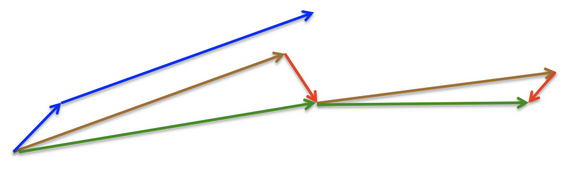

#Experiment 2

This is an extension of the last experiment but with more epochs and early stopping.

In [18]:
# Xv, Yv, req_imprv, attempts
#   validation vectors, required improvement, epochs to hit required improvement
def train_stop(X, Y, model, loss_function, opti, epochs, loss_arr, acc_arr, start, req_imprv, attempts, Xv, Yv):
  model.train()
  last_acc = 0.0
  new_acc = 0.0
  for e in range(epochs):
    acc_arr[e] = new_acc
    x = Variable(X, requires_grad=False).to(dev)
    y = Variable(Y.long(), requires_grad=False).to(dev)
    opti.zero_grad()
    y_hat = model(x)
    loss = loss_function.forward(y_hat, y)
    loss.backward()
    opti.step()
    loss_val = loss.data.cpu().numpy()
    loss_arr[e] = loss_val
    model.eval()
    new_acc = accuracy_score(model.predict(Xv), Yv)
    acc_arr[e] = new_acc
    if e % attempts == 0:
      check = new_acc - last_acc
      if check < req_imprv or check < 0:
        return e
      else:
        last_acc = new_acc
  return e

In [19]:
df2 = init_db()
losses2 = np.zeros(shape=(3,9,1000))
accs2 = np.zeros(shape=(3,9,1000))

run_train_test(train_formants, train_vowels_idx, test_formants, test_vowels_idx, train_stop, 1000, losses2, df2, 
                   acc_arr=accs2, validation=True, val_set_size=1/3, start=None, req_imprv=0.01, attempts=50)

STATUS
___________________________
###########################

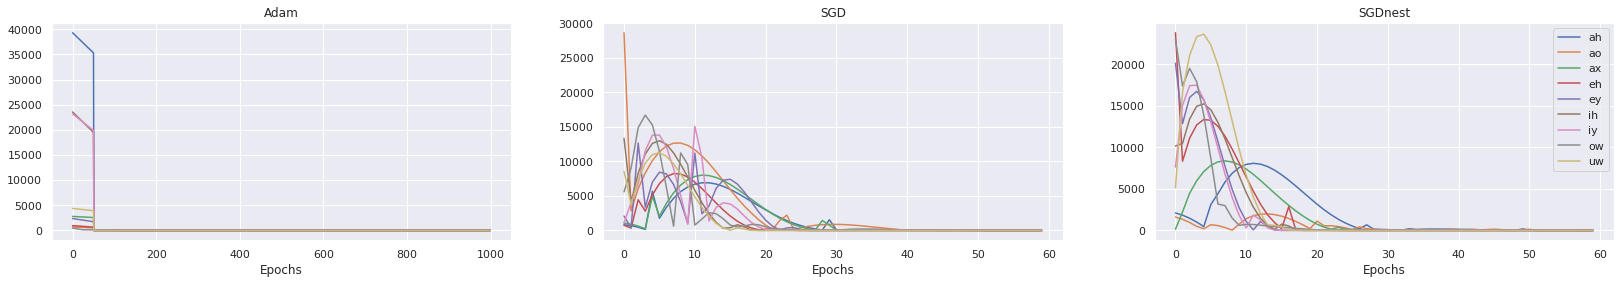

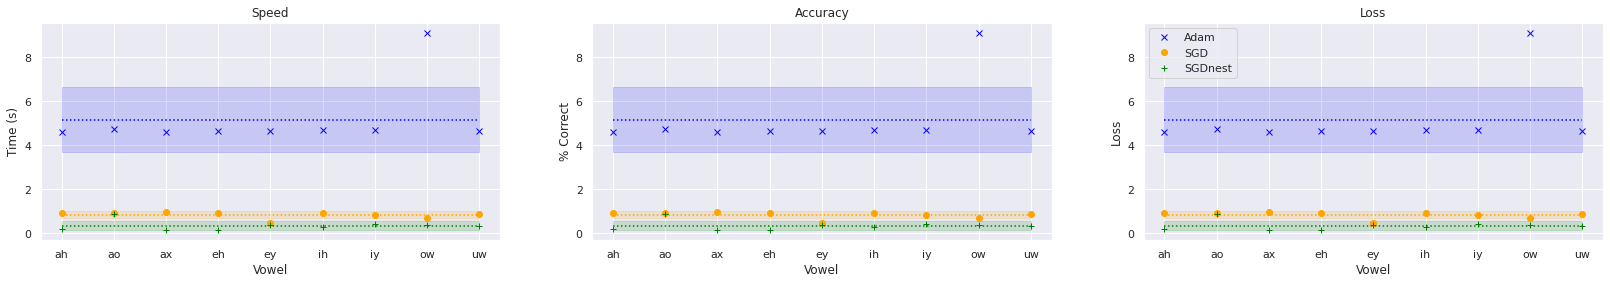

Total training time was 2.4761612097422283 minutes


ah         ao  ...    Average      Stdev
Accuracy Adam      0.064198   0.918519  ...   0.633333   0.399828
         SGD       0.935802   0.918519  ...   0.838409   0.156161
         SGDnest   0.935802   0.917284  ...   0.846776   0.165136
Speed    Adam      4.619824   4.738967  ...   5.155775   1.484780
         SGD       4.687995   4.582704  ...   5.144905   1.527733
         SGDnest   4.738724   4.674737  ...   6.207062   3.253696
Epochs   Adam     50.000000  50.000000  ...  55.555556  16.666667
         SGD      50.000000  50.000000  ...  55.555556  16.666667
         SGDnest  50.000000  50.000000  ...  66.666667  35.355339
Loss     Adam      2.831098   2.319458  ...  29.904142  52.421454
         SGD       0.188181   0.260139  ...   0.320037   0.161400
         SGDnest   0.183166   0.869573  ...   0.347428   0.221338

[12 rows x 11 columns]

In [20]:
df2['Average'] = df2.iloc[:,:-2].mean(axis=1)
df2['Stdev'] = df2.iloc[:,:-2].std(axis=1)
# these bounds effect the x axis on the top 3 graphs. Adjust if cut-off
six_plots([1000,60,60],losses2,df2)
print(f"Total training time was {np.sum(df2.iloc[3:6,:-2].sum(axis=1).to_numpy())/60} minutes")
display(df2)

my implementation of train_stop was naive and it ended up not working too well. Most of the time training ended prematurely either due to my loose constraints or inability to detect local minima. Do I need to use some sort of momentum to get over local minima in the accuracy graph? I think need a way to map my accuracy and loss to a monotonic function-- if it stagnates for long enough, then end training.

I want to graph accuracies over epochs so I can get some insight on how this should be implemented.

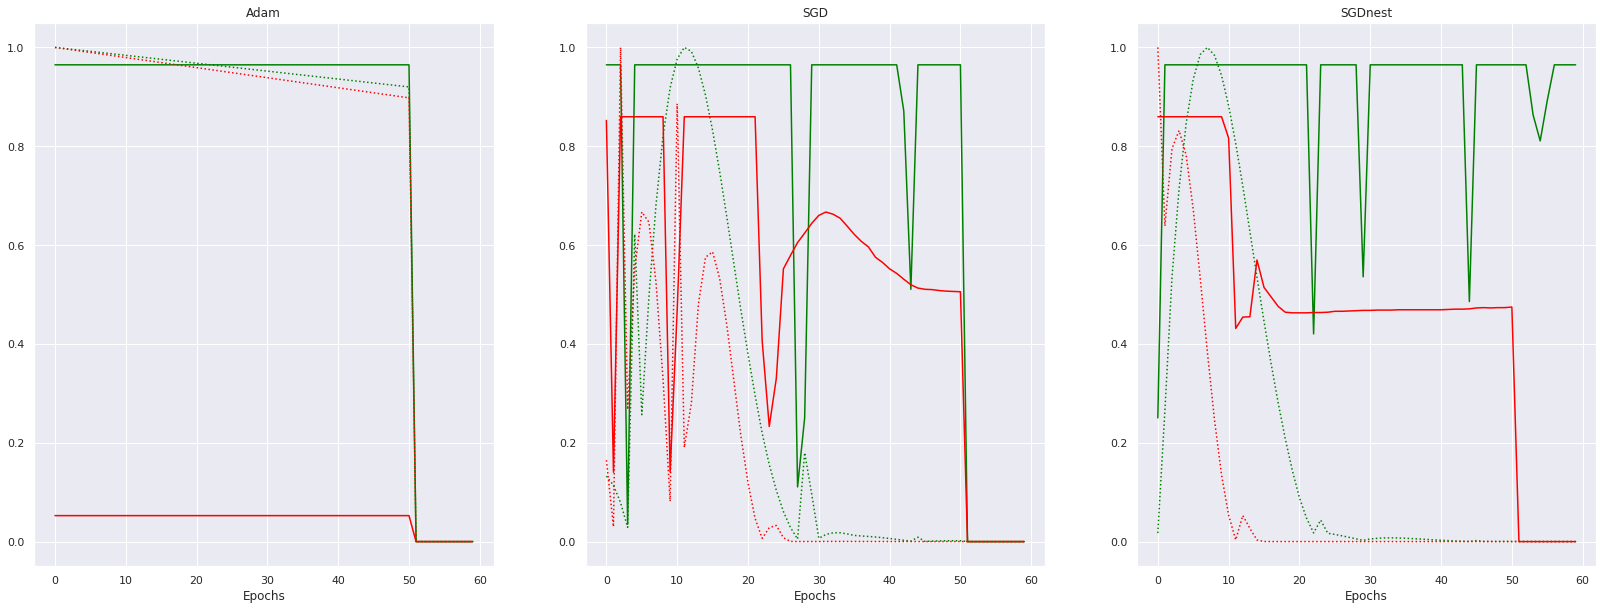

In [21]:
bad = [np.argmin(df2.loc['Accuracy'].to_numpy()[i][:-2]) for i in range(3)]
good = [np.argmax(df2.loc['Accuracy'].to_numpy()[i][:-2]) for i in range(3)]

sns.set(style='darkgrid')
o_names = ['Adam', 'SGD', 'SGDnest']
bounds = [60,60,60]
vowels = list(index_vowels.keys())  
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(28)  
fig.set_figheight(10)   
axs = [ax1,ax2,ax3]
for i, o in enumerate(['Adam', 'SGD', 'SGDnest']):
  axs[i].set_title(o)
  axs[i].set_xlabel('Epochs')

  l1 = losses2[i][bad[i]][:bounds[i]]
  l2 = losses2[i][good[i]][:bounds[i]]
  a1 = accs2[i][bad[i]][:bounds[i]]
  a2 = accs2[i][good[i]][:bounds[i]]

  m1 = np.max(l1)
  m2 = np.max(l2)

  axs[i].plot(a2, color='green')
  axs[i].plot(a1, color='red')

  axs[i].plot(l2/m2, color='green', linestyle='dotted')
  axs[i].plot(l1/m1, color='red', linestyle='dotted')

plt.show()  


Solid lines are accuracies and dotted lines are normalized losses. Red represents the pair that performed the worst and green the best.

At each epoch, I want to find the difference between the accuracy and loss and keep them in a running average. If a calculate a difference that is lower than the average I simply append the average instead. This gives me a function that is either increasing or flat. I can then specify the longest 'flat' strip that is acceptable and stop on the assumption that the accuracy is at its highest and loss at its lowest. These are obviously not continuous functions, if they were, I would start these calculations at the first intersection of (normalized to 0,1) loss and validation accuracy. That intersection likely would never occur here so I use a guess (start) and find the max loss up until there.

In [22]:
def calc_distance(average_distance, max_loss, accuracy, loss, req_imprv):
  dist = accuracy - (loss/max_loss)
  improvement = 1-(average_distance/dist)
  if dist < 0 or improvement < req_imprv:
    dist = average_distance
  return dist

In [23]:
# Xv, Yv, req_imprv, attempts
#   validation vectors, required improvement, epochs to hit required improvement
def train_stop2(X, Y, model, loss_function, opti, epochs, loss_arr, acc_arr, start, req_imprv, attempts, Xv, Yv):
  model.train()
  i = 0
  e = 0
  distances = []
  while e < epochs and i < attempts: 
    # Normal training
    x = Variable(X, requires_grad=False).to(dev)
    y = Variable(Y.long(), requires_grad=False).to(dev)
    opti.zero_grad()
    y_hat = model(x)
    loss = loss_function.forward(y_hat, y)
    loss.backward()
    opti.step()
    loss_val = loss.data.cpu().numpy()
    loss_arr[e] = loss_val
    model.eval()
    acc_val = accuracy_score(model.predict(Xv), Yv)
    acc_arr[e] = acc_val

    # early stop stuff
    if e == start:
      max_loss = np.max(loss_arr)
      distances.append(0)
    if e > start:
      average_distance = np.average(distances)
      distance = calc_distance(average_distance, max_loss, acc_val, loss_val, req_imprv)
      if distance == average_distance:
        i += 2
      else:
        i -= 1
      distances.append(distance)

    e += 1

  return e

In [24]:
df3 = init_db()
losses3 = np.zeros(shape=(3,9,1000))
accs3 = np.zeros(shape=(3,9,1000))

run_train_test(train_formants, train_vowels_idx, test_formants, test_vowels_idx, train_stop2, 1000, losses3, df3, 
                   acc_arr=accs3, validation=True, val_set_size=1/3, start=10, req_imprv=0.01, attempts=5)

STATUS
___________________________
###########################

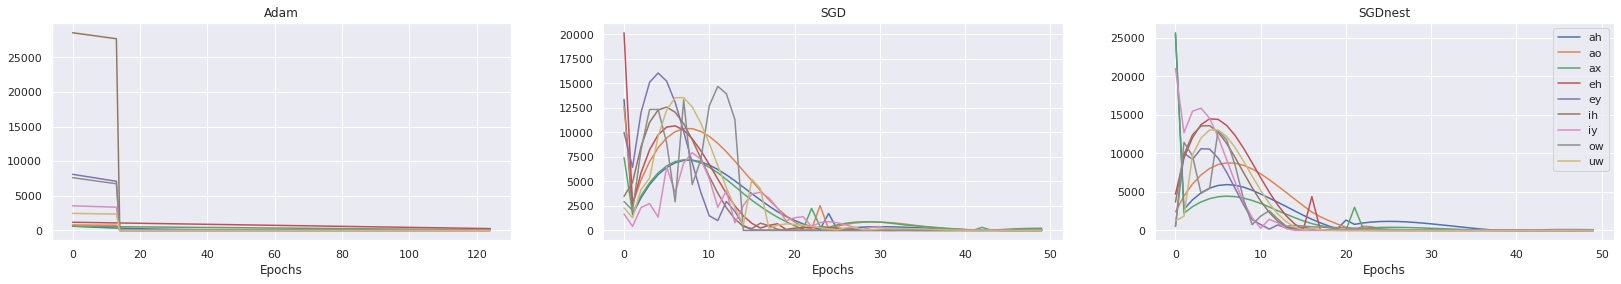

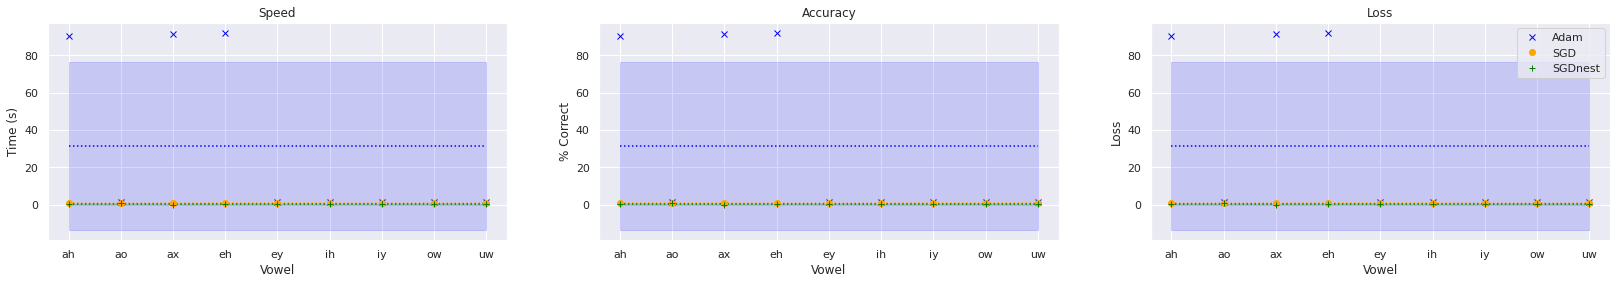

Training time 18.998817686239878 minutes


ah           ao  ...     Average       Stdev
Accuracy Adam        0.927160     0.918519  ...    0.651029    0.376666
         SGD         0.934568     0.751852  ...    0.853909    0.082476
         SGDnest     0.935802     0.918519  ...    0.855556    0.080233
Speed    Adam       90.467322     1.299477  ...   31.282837   45.014845
         SGD        84.431287     9.469638  ...   53.044366   38.097184
         SGDnest    42.045144    90.469026  ...   42.331581   30.649010
Epochs   Adam     1000.000000    14.000000  ...  342.666667  493.000000
         SGD       939.000000   102.000000  ...  590.000000  425.224353
         SGDnest   465.000000  1000.000000  ...  471.111111  341.222231
Loss     Adam        2.831098     2.319458  ...   29.904142   52.421454
         SGD         0.188181     0.260139  ...    0.320037    0.161400
         SGDnest     0.183166     0.869573  ...    0.347428    0.221338

[12 rows x 11 columns]

In [25]:
df3['Average'] = df3.iloc[:,:-2].mean(axis=1)
df3['Stdev'] = df3.iloc[:,:-2].std(axis=1)
six_plots([125, 50, 50], losses3, df3)
print(f"Training time {np.sum(df3.iloc[3:6,:-2].sum(axis=1).to_numpy())/60} minutes")
display(df3)

In [26]:
def loss_acc_plot(df, losses, accs, opti_idx):
  stops = df.loc['Epochs'].to_numpy()
  stops = np.array([stop[:-2] for stop in stops])
  sns.set(style='darkgrid')
  vowels = list(index_vowels.keys())  
  fig, ax = plt.subplots(nrows=3, ncols=3)
  fig.set_figwidth(20)  
  fig.set_figheight(12)

  for i,row in enumerate(ax):
    for j,col in enumerate(row):
      idx = (i*3)+j
      bound = int(stops[opti_idx][idx])
      col.set_title(vowels[idx])
      m = 5*np.max(losses[opti_idx][idx])
      col.plot(losses[opti_idx][idx][:bound]/m, linestyle='dotted')
      col.plot(accs[opti_idx][idx][:bound])
  plt.show()  

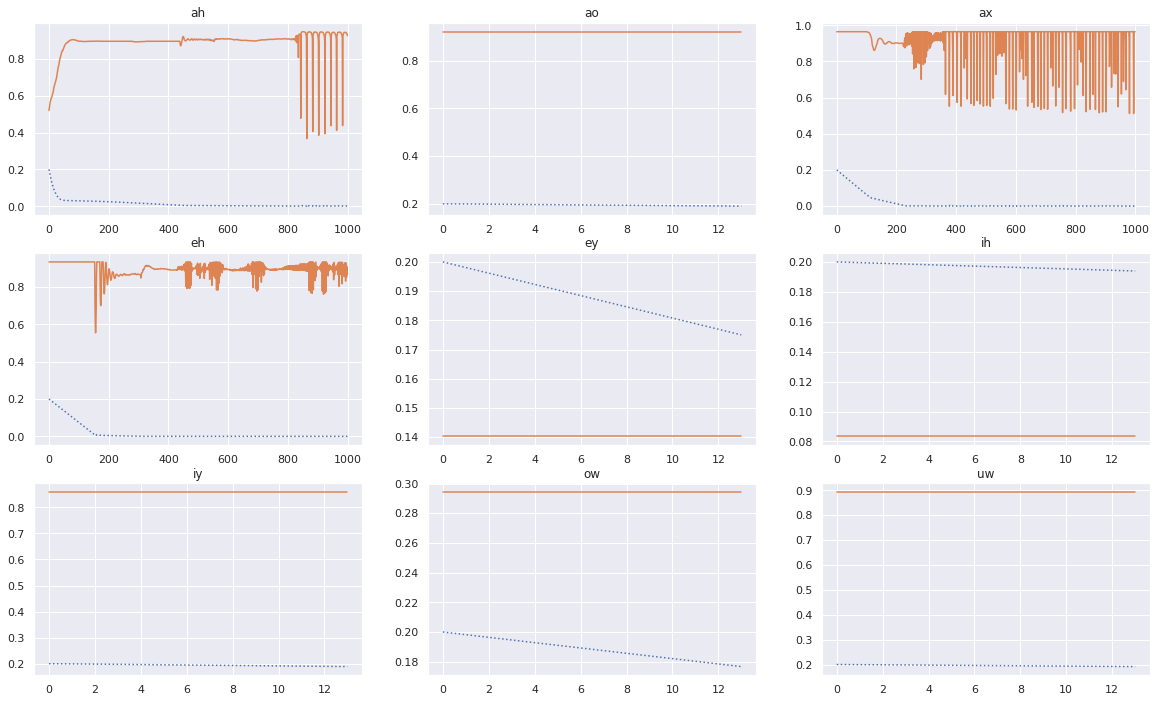

In [27]:
loss_acc_plot(df3, losses3, accs3, 0)

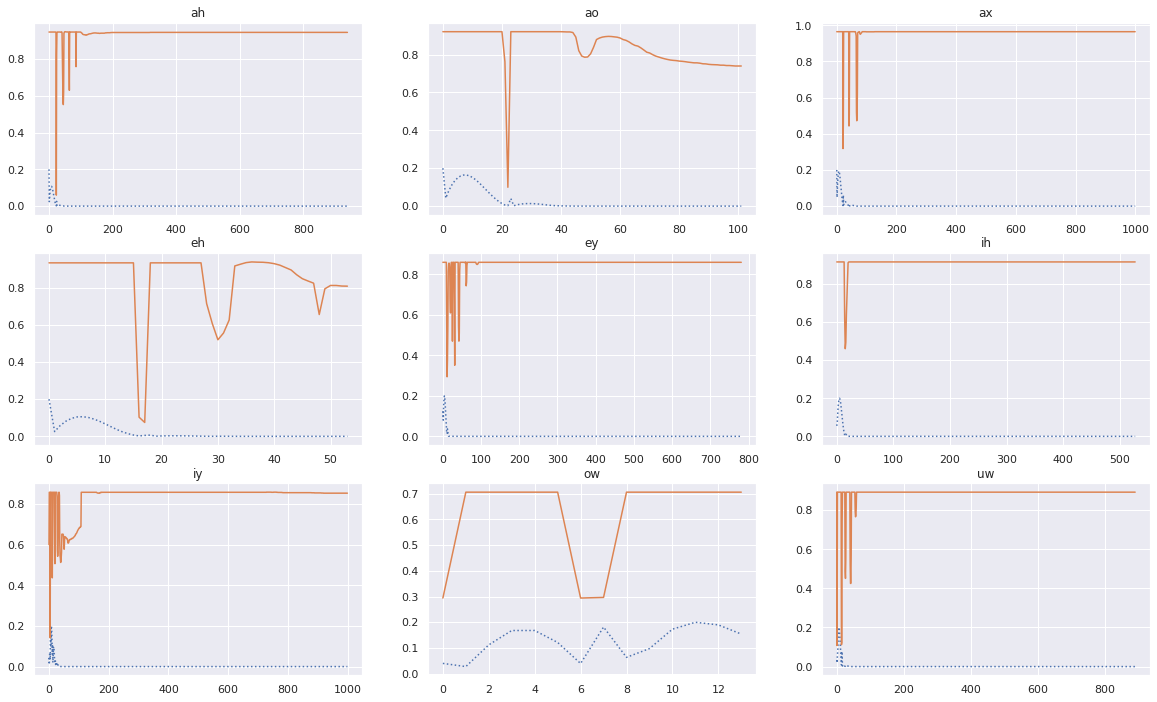

In [28]:
loss_acc_plot(df3, losses3, accs3, 1)

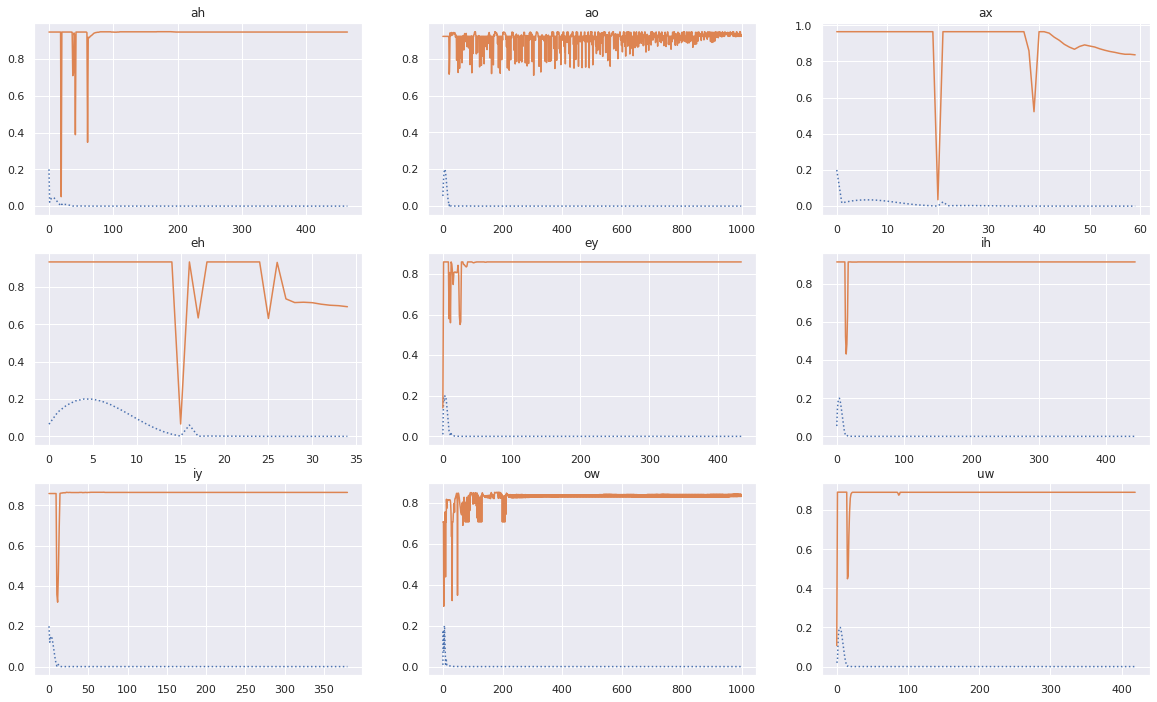

In [29]:
loss_acc_plot(df3, losses3, accs3, 2)

Adam, SGD, and SGDnest respectively. I tried a lot of adjustments but couldn't get interesting graphs on all 3 simultaneously. A future experiment would be to split them up and come up with or read about a better early stopping algorithm.

I started this out with the intent of creating a model that trains faster but  iquickly realized that my early stopping method is significantly more time consuming and would only be useful for avoiding over-fitting. Regarding accuracy, these experiments were a failure, but they gave me insights.